In [129]:
import json
from datetime import datetime
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt

In [131]:
# pd.DataFrame()

def extract(json_file):
    explored_routes = set()
    total_nodes = {}
    total_edges = set()
    for r in json_file["data"]:
        if r["direction"] not in explored_routes:
            explored_routes.add(r["direction"])
        
            stop_ids = {}
            
            idx = 0
            
            for i in r["stops"]:
                stop_ids[idx] = [idx, i["altId"][0], i["lon"], i["lat"], 
                      datetime.strptime(i["depDate"] + " " + i["depTime"], "%Y-%m-%d %H:%M:%S")
                      if "depTime" in i else
                      datetime.strptime(i["arrDate"] + " " + i["arrTime"], "%Y-%m-%d %H:%M:%S")]
                idx += 1
            
            #print(stop_ids)
            
            nodes = {}
            for node in stop_ids:
                nodes[stop_ids[node][1]] = (stop_ids[node][2], stop_ids[node][3])
            
            # nodes
            n_list = list(stop_ids[i][1] for i in stop_ids)
            
            times = [i[-1] for i in stop_ids.values()]
            
            time_zip = zip(times[:-1], times[1:])
            time_deltas = [(t2 - t1).total_seconds() for (t1, t2) in time_zip]
            time_deltas
            
            edges = set(list(zip(n_list[:-1], n_list[1:], time_deltas)))
            
            # edges
            total_edges.update(edges)
            total_nodes.update(nodes)
    return total_nodes, total_edges

In [132]:
# n, e = extract(json_file)

In [133]:
def fetch_route(route_num):
    if f"{route_num}.json" not in os.listdir("bus_routes"):
        print(f"fetching route {route_num} from online")
        with urllib.request.urlopen(f"http://sdgmts-proxy-transit-api-zp6id.ondigitalocean.app/api/schedules/{route_num}") as url:
            data = json.load(url)
        with open(f"bus_routes/{route_num}.json", "w") as f:
            f.write(json.dumps(data))
    else:
        with open(f"bus_routes/{route_num}.json", "r") as f:
            data = json.loads(f.read())
    return data
    # print(data)

In [150]:
routes = [201, 202, 41, 30, 921, 237, *range(1,15), 510, 520, 530, 535]
route_info = {}

for r in routes:
    json_file = fetch_route(r)
    (n, e) = extract(json_file)
    route_info[r] = {"nodes":n,
                    "edges":e}

# route_info

fetching route 510 from online
fetching route 520 from online
fetching route 530 from online
fetching route 535 from online


In [151]:
import networkx as nx
G = nx.DiGraph()

In [152]:
colors = []
for route in route_info:
    route_nodes = route_info[route]["nodes"]
    for id in route_nodes:
        G.add_node(id, pos=route_nodes[id])
    route_edges = route_info[route]["edges"]
    for i in route_edges:
        G.add_edge(i[0], i[1])
        colors.append(route)

import random

bc = list(mcolors.CSS4_COLORS.keys())[15:]

random.shuffle(bc)

colors = [list(bc)[routes.index(i)] for i in colors]

 ...]

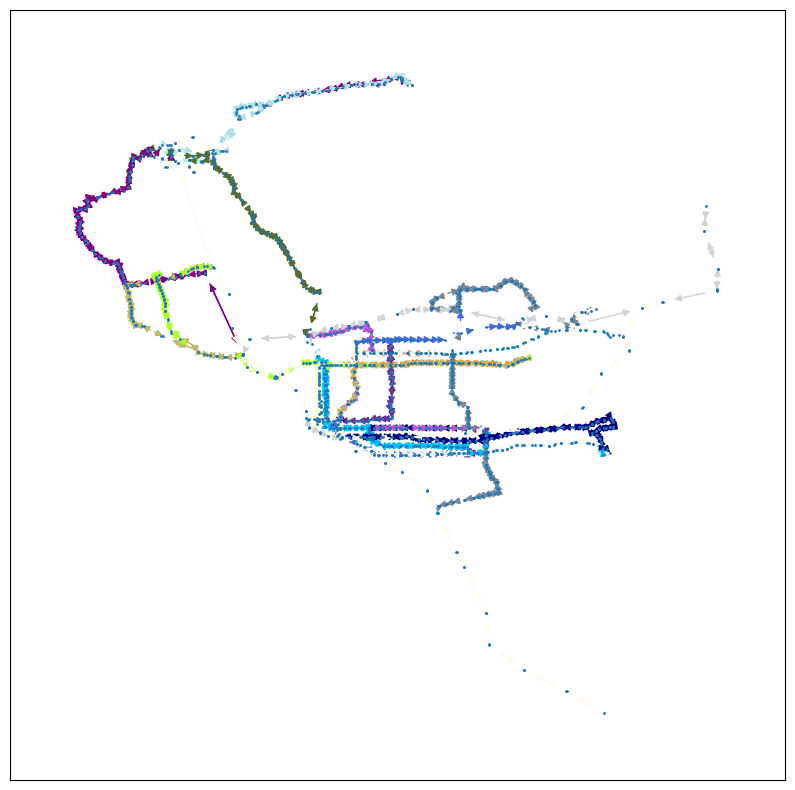

In [153]:
# nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=1)

plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos=pos, node_size = 1)
nx.draw_networkx_edges(G, pos=pos, edge_color=colors)

In [154]:
import matplotlib.colors as mcolors